Lavanderia UPS
Llega vehiculo de tipo: AUTOMOVIL a la hora 0.00.
Llega vehiculo de tipo: BUS a la hora 0.00.
Llega vehiculo de tipo: BUS a la hora 0.00.
Llega vehiculo de tipo: AUTOMOVIL a la hora 0.00.
Llega vehiculo de tipo: FURGONETA a la hora 0.00.
El vehiculo: AUTOMOVIL es trasladado a la lavadora a la hora: 0
TIEMPO TRANSLADO:     =====> 1
El vehiculo: BUS es trasladado a la lavadora a la hora: 0
TIEMPO TRANSLADO:     =====> 4
El vehiculo: BUS es trasladado a la lavadora a la hora: 0
TIEMPO TRANSLADO:     =====> 4
Entra vehiculo a lavarse: AUTOMOVIL a la hora 1.00.
Entra vehiculo a lavarse: BUS a la hora 4.00.
Entra vehiculo a lavarse: BUS a la hora 4.00.
Llega vehiculo de tipo: FURGONETA a la hora 7.00.
Removido  {47%} suciedad vehiculo => AUTOMOVIL 
Vehiculo [AUTOMOVIL] lavado a las 10.00.
El vehiculo: AUTOMOVIL es trasladado a la lavadora a la hora: 10
TIEMPO TRANSLADO:     =====> 1
Entra vehiculo a lavarse: AUTOMOVIL a la hora 11.00.
Removido  {31%} suciedad vehiculo => BUS 


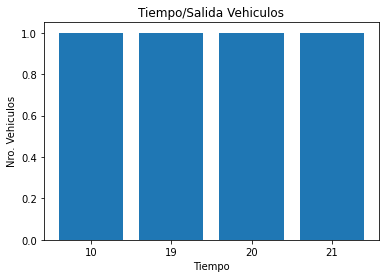

In [8]:
import simpy
import random
import matplotlib.pyplot as plt

%matplotlib inline

# Maximo de vehiculos que puede recibir el negocio
MAX_VEHICULOS = 57
# Total de maquinas de lavado con que cuenta el negocio
NUM_MAQUINAS = 3
# Tiempo que tarda en lavarse un vehiculo (minutos)
TIEMPO_LAVADO = 7
# Intervalo de tiempo en que llegan vehiculos (minutos)
INTERVALO_LLEGADA = 9
# Tiempo de simulación
TIEMPO_SIMULACION = 27

carros = {
    'BUS': (15, 20),
    'AUTOMOVIL': (7, 10),
    'FURGONETA': (12, 15)
}

carro_traslado = {
    'BUS': 4,
    'AUTOMOVIL': 1,
    'FURGONETA': 2
}

class Vehiculo:

    def __init__(self, tipo, tiempo_lavado, tiempo_traslado):
        self.tipo = tipo
        self.tiempo_lavado = random.randint(*tiempo_lavado)
        self.tiempo_traslado = tiempo_traslado

# Creamos un diccionario para almacenar las horas en que se lavan los vehiculos
# Esto permite graficar o generar los resultados
tiempo={}

class Lavanderia(object):

    def __init__(self, environment, num_maquinas, tiempo_lavado):
        # Guardamos como variable el entorno de ejecucion
        self.env=environment
        # Creamos el recurso que representa las maquinas
        self.maquinas = simpy.Resource(environment, num_maquinas)
        # Variable para el tiempo de lavado
        self.tiempo_lavado = tiempo_lavado

    def mover_vehiculo(self, vehiculo: Vehiculo):
        print('TIEMPO TRANSLADO:     =====>', vehiculo.tiempo_traslado)
        yield self.env.timeout(vehiculo.tiempo_traslado)

    def lavar_vehiculo(self, vehiculo: Vehiculo):
        # Este metodo representa el proceso de lavado del vehículo.
        # Se ingresa el vehículo y se lava

        # Simulamos el tiempo que tarda en lavarse el vehiculo
        # Es importante notar que la instruccion "yield" es distinta de "sleep"
        # ya que esta ultima bloquea el hilo de ejecucion durante 't' unidades de tiempo,
        # mientras que 'yield' no bloquea el hilo de ejecucion, solo lo suspende mientras
        # el evento de 'lavado' se realice

        # ---> Modificamos el tiempo de lavado 5-11
        yield self.env.timeout(vehiculo.tiempo_lavado)

        # Simulamos que se ha limpiado parte (%) de la suciedad del vehiculo
        # Para el % generamos un entero entre 30 y 90
        print('Removido  {%d%%} suciedad vehiculo => %s ' % (random.randint(30,90), vehiculo.tipo))


def llegada_vehiculo(env, carro: Vehiculo, lavanderia: Lavanderia):
    # Usamos el reloj de la simulacion (env.now()) para indicar a la
    # hora que llega el vehiculo con el nombre pasado como parametro
    print('Llega vehiculo de tipo: %s a la hora %.2f.' % (carro.tipo, env.now))

    # Especificamos que vamos a usar un recurso (Resource) que representa
    # la maquina de lavado
    with lavanderia.maquinas.request() as maquina:
        # Ocupamos la maquina de lavado
        yield maquina

        print(f'El vehiculo: {carro.tipo} es trasladado a la lavadora a la hora: {env.now}')
        yield env.process(lavanderia.mover_vehiculo(carro))
        # Indicamos que vehiculo entra a la lavanderia
        print('Entra vehiculo a lavarse: %s a la hora %.2f.' % (carro.tipo, env.now))
        # Procesamos la operacion de lavado
        yield env.process(lavanderia.lavar_vehiculo(carro))
        # Una vez que termina la llamada con 'yield', se indica que se ha lavado el vehiculo
        print('Vehiculo [%s] lavado a las %.2f.' % (carro.tipo, env.now))


        # --> Agegamos al diccionario para obtener los tiempos de lavado
        k=env.now # Permite obtener el tiempo actual de la simulación para generar la clave del diccionario
    if k in tiempo:
        tiempo[k]=tiempo[k]+1 # Aumento el numero de autos en el tiempo de salida
    else:
        tiempo[k]=1 # Por defecto empezamos con el primer vehiculo

def get_random_car():
    tipo = random.choice(list(carros.keys()))
    tiempo_lavado = carros.get(tipo)
    tiempo_traslado = carro_traslado.get(tipo)
    return Vehiculo(tipo= tipo, tiempo_lavado= tiempo_lavado, tiempo_traslado= tiempo_traslado)

def ejecutar_simulacion(env, num_maquinas, tiempo_lavado, intervalo):
    lavanderia=Lavanderia(env, num_maquinas, tiempo_lavado)
    # Creamos 5 llegadas de vehiculos iniciales
    for i in range(5):
        env.process(llegada_vehiculo(env, get_random_car(),lavanderia))

    # Ejecutamos la simulacion
    while True:
        yield env.timeout(random.randint(intervalo-3, intervalo+3))
        i+=1
        # Mientras se lavan los vehiculos generamos mas vehiculos
        env.process(llegada_vehiculo(env, get_random_car(),lavanderia))

print('Lavanderia UPS')
# Inicializamos la semilla aleatoria
random.seed(77)

# Creamos el entorno de simulacion
env=simpy.Environment()
env.process(ejecutar_simulacion(env, NUM_MAQUINAS, TIEMPO_LAVADO, INTERVALO_LLEGADA))

# Ejecutamos el proceso durante el tiempo de simulacion
env.run(until = TIEMPO_SIMULACION)

print(tiempo)
# Generamos una grafica en base al diccionario del tiempo
etiqueta = list(tiempo.keys())
valores = list(tiempo.values())
plt.bar(range(len(tiempo)), valores, align="center", tick_label=etiqueta)
plt.title("Tiempo/Salida Vehiculos")
plt.xlabel("Tiempo")
plt.ylabel("Nro. Vehiculos")
plt.show()

Modifique el código anterior a fin de incorporar los siguientes cambios:
Considerar 3 tipos de vehículos con 3 diferentes tiempos de lavado:
  Bus: 15- 20 minutos
  Automóvil: 7-10 minutos
  Furgoneta: 12-15 minutos
  Considere que a partir de la entrada del vehículo para ser lavado, deberán tomarse en cuenta los siguientes tiempos correspondientes al proceso de traslado desde la recepción a la máquina de lavado:
    Bus: 4 minutos
    Automóvil: 1 minuto
    Furgoneta: 2 minutos
    Identificar el recurso maquina dentro de la simulación
    Realice una gráfica comparativa de la simulación con 3 y con 4 máquinas de lavado
    Generar llegada de vehiculos de 1 - 2 minutos, por 60 minutos de lavado, el tipo de vehiculo es generado aleatorialmente.
